In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.spatial import cKDTree
from scipy import ndimage
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.plot import show
import rasterio
import numpy as np
import yaml
import os
import seaborn as sns

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

##### Reproject elevation data for consistency

In [11]:

# Path to the .adf file
elevation_path = resolve_path(config['Africa_Elevation_rast_path'])

# Open the .adf file using rasterio and reproject to EPSG:3857
with rasterio.open(elevation_path) as src:
    dem_crs = src.crs
    if dem_crs != "EPSG:3857":
        transform, width, height = calculate_default_transform(
            src.crs, "EPSG:3857", src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': "EPSG:3857",
            'transform': transform,
            'width': width,
            'height': height,
            'driver': 'GTiff'
        })

        with rasterio.open(resolve_path(config['Africa_Elevation_Reprojected_tif_path']), 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs="EPSG:3857",
                    resampling=Resampling.nearest)
                


##### Load and check the crs of the rest of the data

In [3]:
# Load the dam gdf and reproject
gdf_dams_path = resolve_path(config['Africa_Dam_All_shp_path'])
gdf_dams = gpd.read_file(gdf_dams_path)
gdf_dams = gdf_dams.to_crs(epsg=3857)
print(gdf_dams.crs)

# Load the reprojected CPIS gdf
gdf_cpis_path = resolve_path(config['Combined_CPIS_Reproj_shp_path'])
gdf_cpis = gpd.read_file(gdf_cpis_path)
print(gdf_cpis.crs)

# Load the reprojected Area Equipt for Irrigation (AEI) gdf
gdf_aei_path = resolve_path(config['AEI_2015_reproj_gpkg_path'])
gdf_aei = gpd.read_file(gdf_aei_path)
print(gdf_cpis.crs)

# Load the reprojected Cropland gdf
gdf_cropland_path = resolve_path(config['Arid_Cropland_by_Country_shp_path'])
gdf_cropland = gpd.read_file(gdf_cropland_path)
print(gdf_cropland.crs)

EPSG:4326
EPSG:3857
EPSG:3857
EPSG:3857
EPSG:3857


Find Gradients For Reprojected Elevation Data

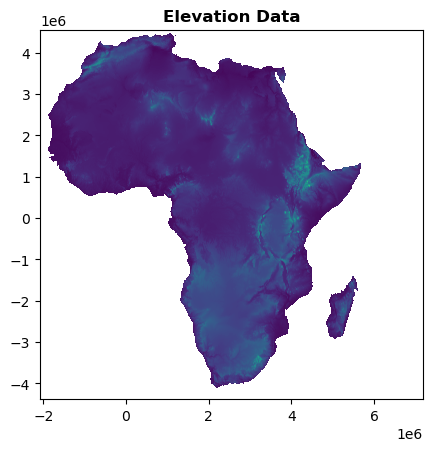

In [22]:

# Load elevation data
elevation_tif_path = resolve_path(config['Africa_Elevation_Reprojected_tif_path'])

with rasterio.open(elevation_tif_path) as src:
    elevation_data = src.read(1)
    elevation_transform = src.transform
    show(src, title="Elevation Data")

# Calculate the gradients (as before)
gradient_y, gradient_x = np.gradient(elevation_data, abs(elevation_transform[4]), elevation_transform[0])

# Calculate the direction of the gradient
gradient_direction = np.arctan2(gradient_y, gradient_x)

# Normalize to degrees
gradient_direction_degrees = np.degrees(gradient_direction)


In [34]:
def calculate_nearest_dam_index(src_gdf, target_gdf):
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    tree = cKDTree(target_points)
    _, indices = tree.query(src_centroids, k=1)
    
    return indices

# Function to classify upstream or downstream
def classify_stream_position(gdf, dams_gdf, gradient_direction, transform):
    positions = []
    for index, row in gdf.iterrows():
        point = row.geometry.centroid
        col_idx, row_idx = ~transform * (point.x, point.y)
        row_idx, col_idx = int(row_idx), int(col_idx)
        
        nearest_dam = dams_gdf.iloc[row.nearest_dam_idx].geometry.centroid
        dam_direction = np.arctan2(nearest_dam.y - point.y, nearest_dam.x - point.x)
        dam_direction_degrees = np.degrees(dam_direction)

        # Compare the gradient direction with the direction to the nearest dam
        angle_diff = (gradient_direction_degrees[row_idx, col_idx] - dam_direction_degrees + 180) % 360 - 180
        if abs(angle_diff) < 90:
            positions.append('downstream')
        else:
            positions.append('upstream')
    return positions

# Function to calculate distances
def calculate_distances(src_gdf, target_gdf):
    src_centroids = np.array(list(src_gdf.geometry.centroid.apply(lambda geom: (geom.x, geom.y))))
    target_points = np.array(list(target_gdf.geometry.apply(lambda geom: (geom.x, geom.y))))
    
    tree = cKDTree(target_points)
    dists, _ = tree.query(src_centroids, k=1)
    
    return dists

# Function to adjust distances for upstream/downstream classification
def adjust_distances(distances, positions):
    adjusted_distances = []
    for distance, position in zip(distances, positions):
        if position == 'upstream':
            adjusted_distances.append(-distance)  # Negative for upstream
        else:
            adjusted_distances.append(distance)  # Positive for downstream
    return adjusted_distances

# Calculate nearest dam index for each CPIS, AEI, and cropland
gdf_cpis['nearest_dam_idx'] = calculate_nearest_dam_index(gdf_cpis, gdf_dams)
gdf_aei['nearest_dam_idx'] = calculate_nearest_dam_index(gdf_aei, gdf_dams)
gdf_cropland['nearest_dam_idx'] = calculate_nearest_dam_index(gdf_cropland, gdf_dams)

# Calculate positions
positions_cpis = classify_stream_position(gdf_cpis, gdf_dams, gradient_direction_degrees, elevation_transform)
positions_aei = classify_stream_position(gdf_aei, gdf_dams, gradient_direction_degrees, elevation_transform)
positions_cropland = classify_stream_position(gdf_cropland, gdf_dams, gradient_direction_degrees, elevation_transform)

# Calculate distances
distances_cpis_to_dams = calculate_distances(gdf_cpis, gdf_dams)
distances_aei_to_dams = calculate_distances(gdf_aei, gdf_dams)
distances_cropland_to_dams = calculate_distances(gdf_cropland, gdf_dams)

# Adjust distances for plotting
adjusted_distances_cropland = adjust_distances(distances_cropland_to_dams, positions_cropland)
adjusted_distances_cpis = adjust_distances(distances_cpis_to_dams, positions_cpis)
adjusted_distances_aei = adjust_distances(distances_aei_to_dams, positions_aei)

for i in range(10):
    print(f"Original: {distances_cropland_to_dams[i]}, Position: {positions_cropland[i]}, Adjusted: {adjusted_distances_cropland[i]}")


Original: 210294.50876798117, Position: upstream, Adjusted: -210294.50876798117
Original: 218866.260522502, Position: upstream, Adjusted: -218866.260522502
Original: 171952.7538590841, Position: upstream, Adjusted: -171952.7538590841
Original: 180285.42740785124, Position: upstream, Adjusted: -180285.42740785124
Original: 197308.60913394042, Position: upstream, Adjusted: -197308.60913394042
Original: 205969.54475164565, Position: upstream, Adjusted: -205969.54475164565
Original: 232415.81798047377, Position: upstream, Adjusted: -232415.81798047377
Original: 241357.5198239972, Position: downstream, Adjusted: 241357.5198239972
Original: 147997.6959246412, Position: upstream, Adjusted: -147997.6959246412
Original: 156418.0835910507, Position: downstream, Adjusted: 156418.0835910507


Visualizing Classification Function

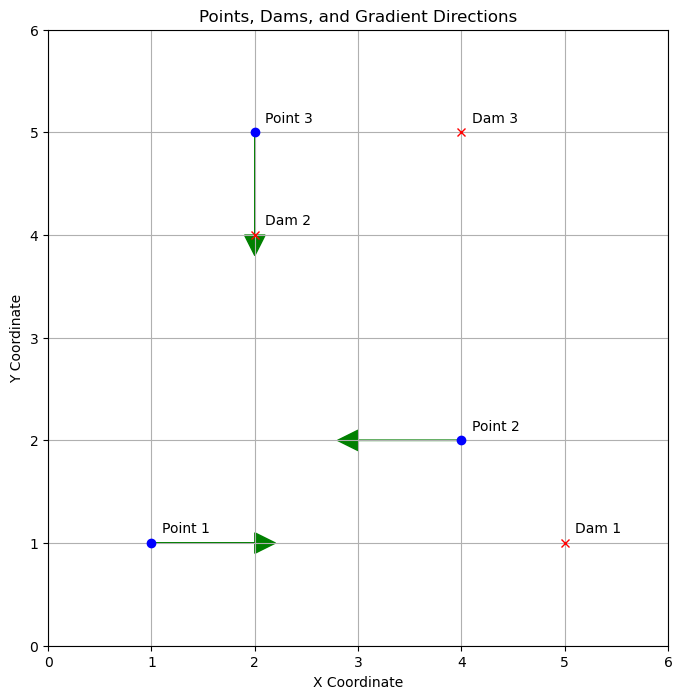

In [ ]:
import matplotlib.pyplot as plt

# Example point and dam locations (these would be extracted from your data)
points = [(1, 1), (4, 2), (2, 5)]  # Example points (CPIS, AEI, etc.)
dams = [(5, 1), (2, 4), (4, 5)]   # Example dam locations

# Gradient direction as arrows (simplified for example)
gradient_directions = [(1, 0), (-1, 0), (0, -1)]  # Example directions

plt.figure(figsize=(8, 8))

# Plot points
for i, (px, py) in enumerate(points):
    plt.plot(px, py, 'bo')
    plt.annotate(f'Point {i+1}', (px + 0.1, py + 0.1))

# Plot dams
for i, (dx, dy) in enumerate(dams):
    plt.plot(dx, dy, 'rx')
    plt.annotate(f'Dam {i+1}', (dx + 0.1, dy + 0.1))

# Plot gradient directions
for i, (px, py) in enumerate(points):
    gx, gy = gradient_directions[i]
    plt.arrow(px, py, gx, gy, head_width=0.2, head_length=0.2, fc='g', ec='g')

plt.xlim(0, 6)
plt.ylim(0, 6)
plt.grid(True)
plt.title('Points, Dams, and Gradient Directions')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.show()


In [35]:

# DataFrames for plotting Cropland Figure
df_cropland_vs_cpis = pd.DataFrame({
    'distance': adjusted_distances_cropland + adjusted_distances_cpis,
    'type': ['Cropland'] * len(adjusted_distances_cropland) + ['CPIS'] * len(adjusted_distances_cpis)
})

# Convert distances from meters to kilometers
df_cropland_vs_cpis['distance_km'] = df_cropland_vs_cpis['distance'] / 1000


# DataFrames for plotting AEI Figure
df_aei_vs_cpis = pd.DataFrame({
    'distance': adjusted_distances_aei + adjusted_distances_cpis,
    'type': ['AEI'] * len(adjusted_distances_aei) + ['CPIS'] * len(adjusted_distances_cpis)
})

# Convert distances from meters to kilometers
df_aei_vs_cpis['distance_km'] = df_aei_vs_cpis['distance'] / 1000

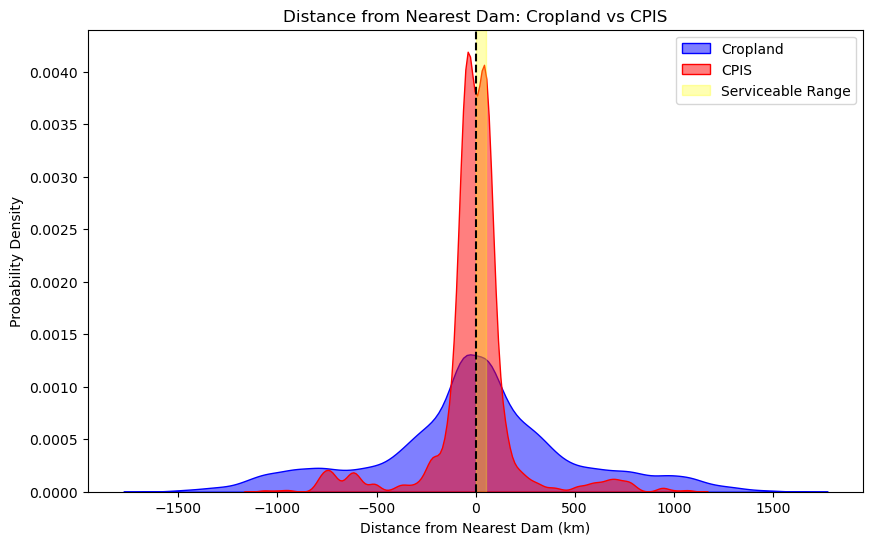

In [31]:
# Plot cropland vs CPIS with x-axis in kilometers
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_cropland_vs_cpis[df_cropland_vs_cpis['type'] == 'Cropland'], x='distance_km', fill=True, common_norm=False, alpha=0.5, label='Cropland', color='blue')
sns.kdeplot(data=df_cropland_vs_cpis[df_cropland_vs_cpis['type'] == 'CPIS'], x='distance_km', fill=True, common_norm=False, alpha=0.5, label='CPIS', color='red')
plt.axvline(x=0, linestyle='--', color='black')
plt.xlabel('Distance from Nearest Dam (km)')
plt.ylabel('Probability Density')
plt.title('Distance from Nearest Dam: Cropland vs CPIS')
plt.legend(title='Type')

# Highlight the serviceable range (up to 50 km downstream)
serviceable_range_km = 50  # 50 km
plt.axvspan(0, serviceable_range_km, color='yellow', alpha=0.3, label='Serviceable Range')

plt.legend()
plt.show()

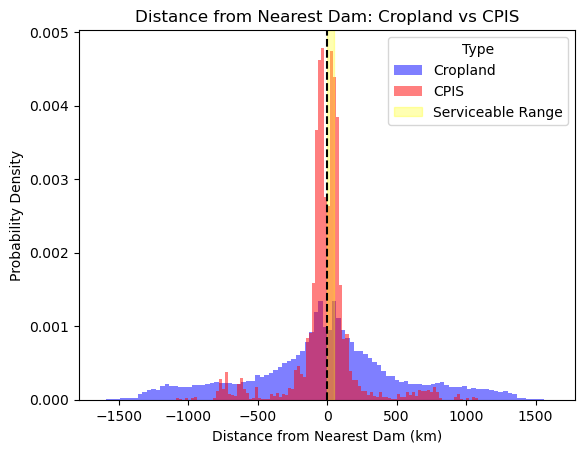

In [36]:
# Histogram for Cropland
plt.hist(df_cropland_vs_cpis[df_cropland_vs_cpis['type'] == 'Cropland']['distance_km'], 
         bins=100, alpha=0.5, label='Cropland', color='blue', density=True)

# Histogram for CPIS
plt.hist(df_cropland_vs_cpis[df_cropland_vs_cpis['type'] == 'CPIS']['distance_km'], 
         bins=100, alpha=0.5, label='CPIS', color='red', density=True)

# Vertical line at x=0
plt.axvline(x=0, linestyle='--', color='black')

# Highlight the serviceable range (up to 50 km downstream)
serviceable_range_km = 50  # 50 km
plt.axvspan(0, serviceable_range_km, color='yellow', alpha=0.3, label='Serviceable Range')

# Labels and title
plt.xlabel('Distance from Nearest Dam (km)')
plt.ylabel('Probability Density')
plt.title('Distance from Nearest Dam: Cropland vs CPIS')

# Legend
plt.legend(title='Type')

# Show plot
plt.show()

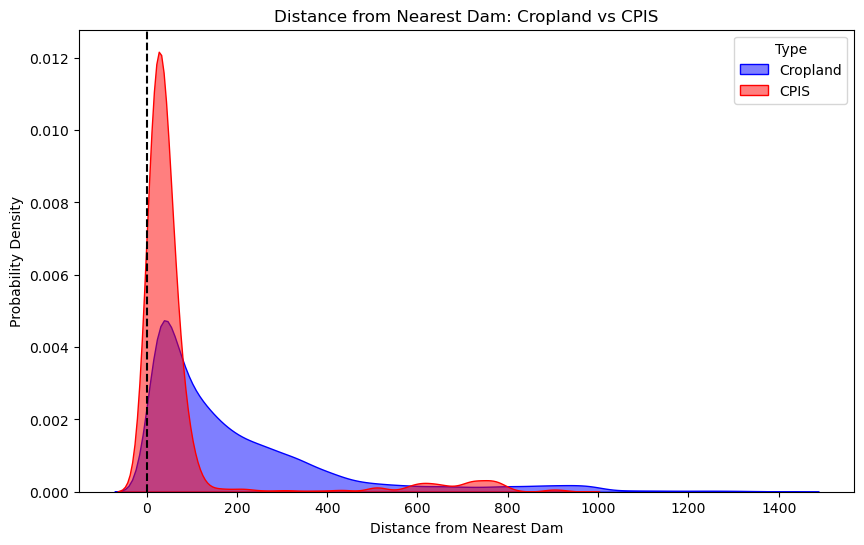

In [ ]:

# Plot cropland vs CPIS
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_cropland_vs_cpis[df_cropland_vs_cpis['type'] == 'Cropland'], x='distance_km', fill=True, common_norm=False, alpha=0.5, label='Cropland', color='blue')
sns.kdeplot(data=df_cropland_vs_cpis[df_cropland_vs_cpis['type'] == 'CPIS'], x='distance_km', fill=True, common_norm=False, alpha=0.5, label='CPIS', color='red')
plt.axvline(x=0, linestyle='--', color='black')
plt.xlabel('Distance from Nearest Dam')
plt.ylabel('Probability Density')
plt.title('Distance from Nearest Dam: Cropland vs CPIS')
plt.legend(title='Type')
plt.show()


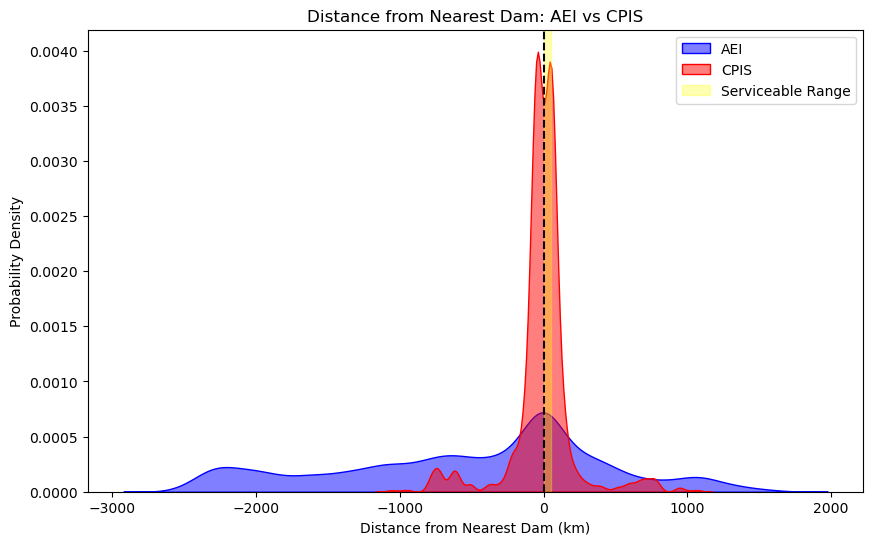

In [37]:
# Plot AEI vs CPIS with x-axis in kilometers
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_aei_vs_cpis[df_aei_vs_cpis['type'] == 'AEI'], x='distance_km', fill=True, common_norm=False, alpha=0.5, label='AEI', color='blue')
sns.kdeplot(data=df_aei_vs_cpis[df_aei_vs_cpis['type'] == 'CPIS'], x='distance_km', fill=True, common_norm=False, alpha=0.5, label='CPIS', color='red')
plt.axvline(x=0, linestyle='--', color='black')
plt.xlabel('Distance from Nearest Dam (km)')
plt.ylabel('Probability Density')
plt.title('Distance from Nearest Dam: AEI vs CPIS')
plt.legend(title='Type')

# Highlight the serviceable range (up to 50 km downstream)
serviceable_range_km = 50  # 50 km
plt.axvspan(0, serviceable_range_km, color='yellow', alpha=0.3, label='Serviceable Range')

plt.legend()
plt.show()

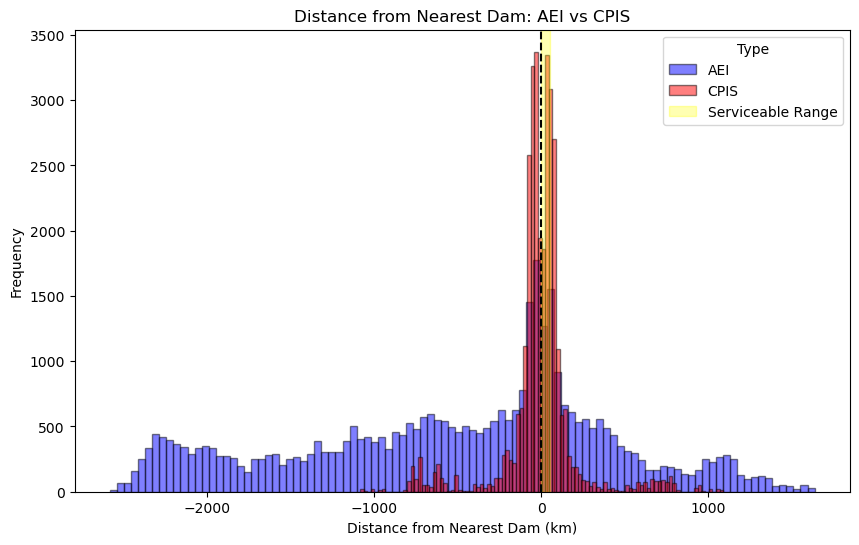

In [38]:
import matplotlib.pyplot as plt

# Set up the figure size
plt.figure(figsize=(10, 6))

# Plot histograms for AEI and CPIS
plt.hist(df_aei_vs_cpis[df_aei_vs_cpis['type'] == 'AEI']['distance_km'], bins=100, alpha=0.5, label='AEI', color='blue', edgecolor='black')
plt.hist(df_aei_vs_cpis[df_aei_vs_cpis['type'] == 'CPIS']['distance_km'], bins=100, alpha=0.5, label='CPIS', color='red', edgecolor='black')

# Add a vertical line at x = 0
plt.axvline(x=0, linestyle='--', color='black')

# Label the x-axis and y-axis
plt.xlabel('Distance from Nearest Dam (km)')
plt.ylabel('Frequency')

# Add a title
plt.title('Distance from Nearest Dam: AEI vs CPIS')

# Highlight the serviceable range (up to 50 km downstream)
serviceable_range_km = 50  # 50 km
plt.axvspan(0, serviceable_range_km, color='yellow', alpha=0.3, label='Serviceable Range')

# Add a legend
plt.legend(title='Type')

# Display the plot
plt.show()


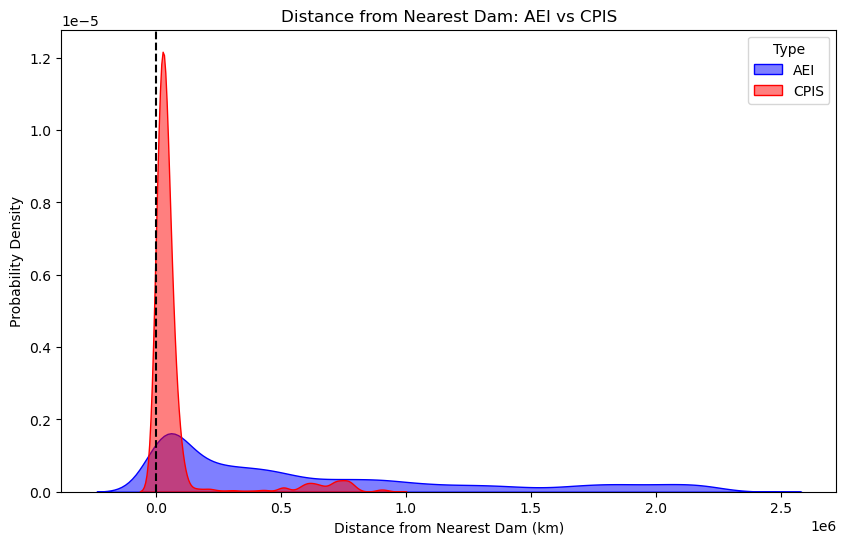

In [ ]:


# Plot AEI vs CPIS
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_aei_vs_cpis[df_aei_vs_cpis['type'] == 'AEI'], x='distance', fill=True, common_norm=False, alpha=0.5, label='AEI', color='blue')
sns.kdeplot(data=df_aei_vs_cpis[df_aei_vs_cpis['type'] == 'CPIS'], x='distance', fill=True, common_norm=False, alpha=0.5, label='CPIS', color='red')
plt.axvline(x=0, linestyle='--', color='black')
plt.xlabel('Distance from Nearest Dam (km)')
plt.ylabel('Probability Density')
plt.title('Distance from Nearest Dam: AEI vs CPIS')
plt.legend(title='Type')
plt.show()


/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


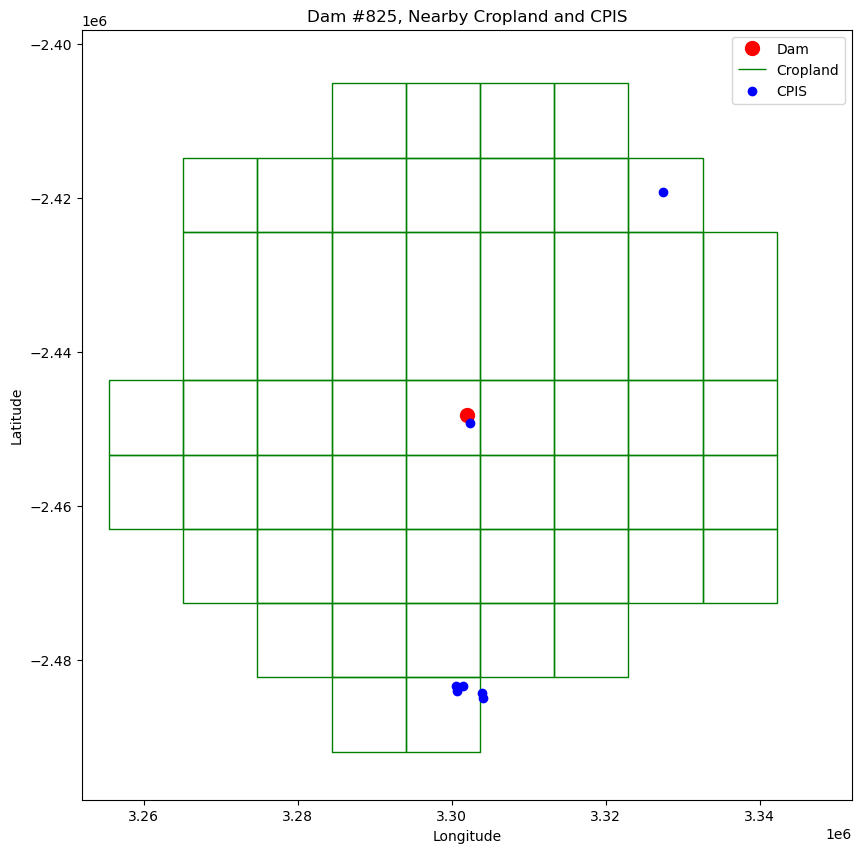

In [ ]:
# Choose a specific dam by its index
specific_dam_idx = 825  # Replace with the index of the dam you're interested in

# Extract the specific dam's location
specific_dam = gdf_dams.iloc[specific_dam_idx]

from shapely.geometry import Point

# Define a search radius (in meters, adjust as needed)
search_radius = 50000  # 50 km

# Create a buffer around the dam
dam_buffer = specific_dam.geometry.buffer(search_radius)

# Filter cropland and CPIS within this buffer
cropland_near_dam = gdf_cropland[gdf_cropland.geometry.within(dam_buffer)]
cpis_near_dam = gdf_cpis[gdf_cpis.geometry.within(dam_buffer)]

# Convert the bounding box of the dam buffer to pixel coordinates
minx, miny, maxx, maxy = dam_buffer.bounds
row_start, col_start = ~elevation_transform * (minx, maxy)
row_end, col_end = ~elevation_transform * (maxx, miny)
row_start, col_start = int(row_start), int(col_start)
row_end, col_end = int(row_end), int(col_end)

# Extract the gradient data for this area
gradient_x_subset = gradient_x[row_start:row_end, col_start:col_end]
gradient_y_subset = gradient_y[row_start:row_end, col_start:col_end]

import matplotlib.pyplot as plt

# Plot the gradient
plt.figure(figsize=(10, 10))
plt.quiver(
    np.linspace(minx, maxx, gradient_x_subset.shape[1]),
    np.linspace(miny, maxy, gradient_y_subset.shape[0]),
    gradient_x_subset, gradient_y_subset,
    color='gray', alpha=0.5
)

# Plot the dam
plt.plot(specific_dam.geometry.x, specific_dam.geometry.y, 'ro', markersize=10, label='Dam')

# Plot cropland
cropland_near_dam.boundary.plot(ax=plt.gca(), color='green', linewidth=1, label='Cropland')

# Plot CPIS points (using centroids if they are polygons)
cpis_centroids = cpis_near_dam.geometry.centroid
plt.scatter(cpis_centroids.x, cpis_centroids.y, color='blue', label='CPIS', zorder=5)

# Set the plot limits to focus on the area around the dam
plt.xlim(minx, maxx)
plt.ylim(miny, maxy)

# Add legend and title
plt.legend()
plt.title(f'Dam #{specific_dam_idx}, Nearby Cropland and CPIS')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Show the plot
plt.show()

# 819,  

Selected Dam #0 with CPIS downstream within 50 km.


/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: divide by zero encountered in scalar divide
  length = a * (widthu_per_lenu / (self.scale * self.width))
/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/matplotlib/quiver.py:649: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


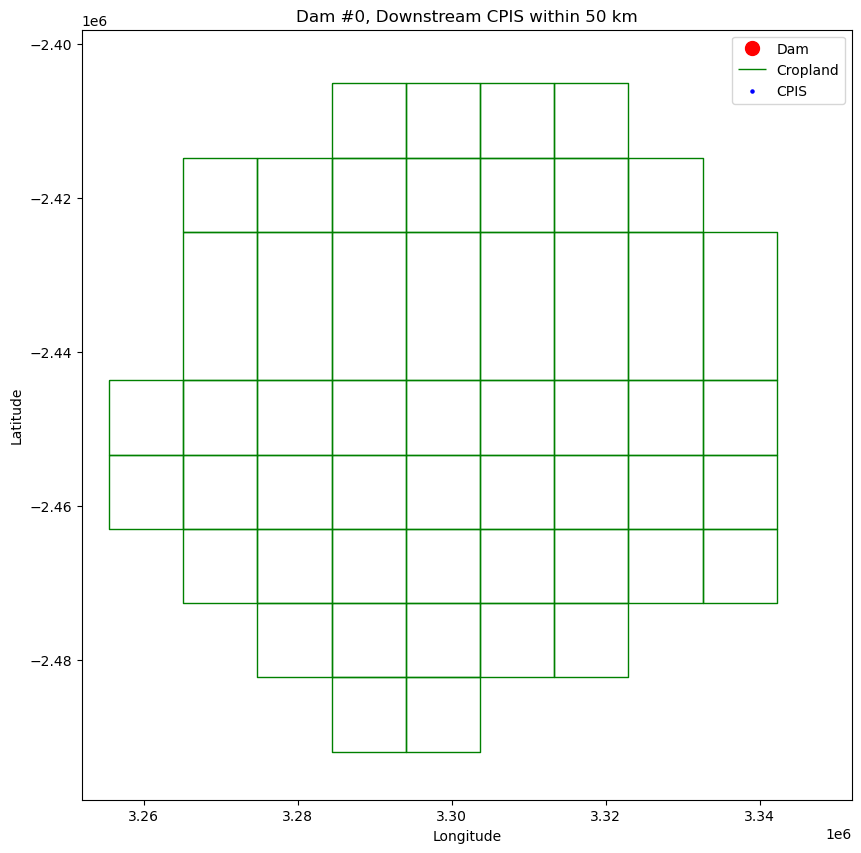

In [ ]:
from shapely.geometry import Point

# Function to classify upstream or downstream
def classify_stream_position_for_point(dam_point, cpis_point, gradient_direction, transform):
    row_idx, col_idx = ~transform * (cpis_point.x, cpis_point.y)
    row_idx, col_idx = int(row_idx), int(col_idx)
    
    # Get the direction to the dam
    dam_direction = np.arctan2(dam_point.y - cpis_point.y, dam_point.x - cpis_point.x)
    dam_direction_degrees = np.degrees(dam_direction)

    # Compare the gradient direction with the direction to the dam
    if abs(gradient_direction[row_idx, col_idx] - dam_direction_degrees) < 90:
        return 'downstream'
    else:
        return 'upstream'

# Loop through each dam to find one with CPIS downstream within 50 km
for dam_idx, dam_row in gdf_dams.iterrows():
    dam_point = dam_row.geometry
    
    # Create a buffer around the dam
    search_radius = 50000  # 50 km
    dam_buffer = dam_point.buffer(search_radius)

    # Filter CPIS within this buffer
    cpis_near_dam = gdf_cpis[gdf_cpis.geometry.within(dam_buffer)]

    # Check for downstream CPIS
    downstream_cpis = []
    for cpis_idx, cpis_row in cpis_near_dam.iterrows():
        cpis_point = cpis_row.geometry.centroid
        position = classify_stream_position_for_point(dam_point, cpis_point, gradient_direction_degrees, elevation_transform)
        if position == 'downstream':
            downstream_cpis.append(cpis_row)
    
    # If we find downstream CPIS, we select this dam
    if downstream_cpis:
        specific_dam_idx = dam_idx
        specific_dam = dam_row
        downstream_cpis_df = gpd.GeoDataFrame(downstream_cpis, crs=gdf_cpis.crs)
        print(f"Selected Dam #{specific_dam_idx} with CPIS downstream within 50 km.")
        break
else:
    print("No dam found with CPIS downstream within 50 km.")

# Now, plot or work with the selected dam and downstream CPIS
if 'specific_dam' in locals():
    # Plotting as before, but now focusing on the selected dam and downstream CPIS
    plt.figure(figsize=(10, 10))
    plt.quiver(
        np.linspace(minx, maxx, gradient_x_subset.shape[1]),
        np.linspace(miny, maxy, gradient_y_subset.shape[0]),
        gradient_x_subset, gradient_y_subset,
        color='gray', alpha=0.5
    )

    # Plot the selected dam
    plt.plot(specific_dam.geometry.x, specific_dam.geometry.y, 'ro', markersize=10, label='Dam')

    # Plot cropland (adjust this as necessary)
    cropland_near_dam.boundary.plot(ax=plt.gca(), color='green', linewidth=1, label='Cropland')

    # Plot the downstream CPIS
    downstream_cpis_df.geometry.centroid.plot(ax=plt.gca(), color='blue', label='CPIS', zorder=5, markersize=5)

    # Set the plot limits to focus on the area around the dam
    plt.xlim(minx, maxx)
    plt.ylim(miny, maxy)

    # Add legend and title
    plt.legend()
    plt.title(f'Dam #{specific_dam_idx}, Downstream CPIS within 50 km')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Show the plot
    plt.show()
